# Scalable Diffusion Models with Transformer (DiT)

This notebook samples from pre-trained DiT models. DiTs are class-conditional latent diffusion models trained on ImageNet that use transformers in place of U-Nets as the DDPM backbone. DiT outperforms all prior diffusion models on the ImageNet benchmarks.

[Project Page](https://www.wpeebles.com/DiT) | [HuggingFace Space](https://huggingface.co/spaces/wpeebles/DiT) | [Paper](http://arxiv.org/abs/2212.09748) | [GitHub](github.com/facebookresearch/DiT)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the DiT GitHub repo and setup PyTorch. You only have to run this once.

In [3]:
import os
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

/home/AD/xiw136/anaconda3/envs/DiT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'download'

# Download DiT-XL/2 Models

You can choose between a 512x512 model and a 256x256 model. You can swap-out the LDM VAE, too.

In [ ]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8 #32*32, 64*64
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

100%|██████████| 2700611775/2700611775 [00:25<00:00, 105879666.00it/s]


# 2. Sample from Pre-trained DiT Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [ ]:
import torch
latent_size = 32
n = 8
z = torch.randn(n, 4, latent_size, latent_size)
print(z.shape)
z = torch.cat([z, z], 0) 
print(z.shape)

torch.Size([8, 4, 32, 32])
torch.Size([16, 4, 32, 32])


100%|██████████| 250/250 [05:15<00:00,  1.26s/it]


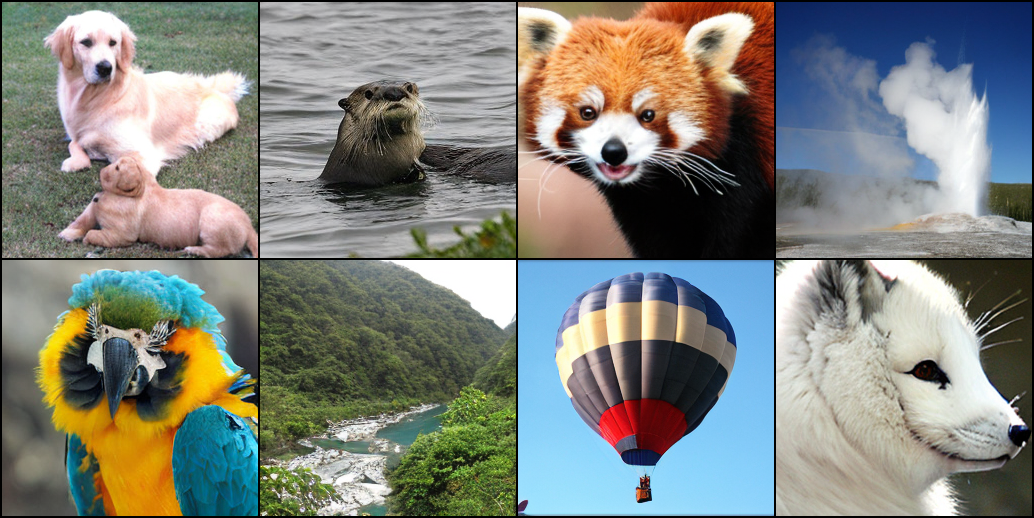

In [ ]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device) # [n, 4, latent_size, latent_size
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)  #[2*n, 4, latent_size, latent_size]
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [ ]:
import torch
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        return x

In [ ]:
class MLP(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展平特征图
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [ ]:
data = torch.rand((5, 3, 32, 32))

In [ ]:
cnn_output.shape

torch.Size([5, 32, 8, 8])

In [ ]:
mlp_output.shape

torch.Size([5, 1])

In [ ]:
cnn

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
class Classifier(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.cnn = CNN()
        self.mlp = MLP()

    def forward(self, x):
        x = self.cnn(x)
        x = self.mlp(x)
        return x

In [ ]:
clf = Classifier()

In [ ]:
cnn = CNN()
mlp = MLP()
for param in mlp.parameters():
    param.requires_grad = False
data = torch.rand((5, 3, 32, 32))
label = torch.rand((5,1))

In [ ]:
import torch.optim as optim

criterion = nn.L1Loss()

# 定义优化器
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9)
optimizer.zero_grad()

cnn_output = cnn(data)
mlp_output = mlp(cnn_output)

In [ ]:
loss = criterion(mlp_output, label)
loss.backward()

In [ ]:
for param in cnn.parameters():
    print(param.grad)

tensor([[[[-7.1220e-03, -5.6623e-03, -5.2703e-03],
          [-7.8948e-03, -1.5372e-02, -3.4734e-03],
          [-1.1933e-03, -6.3104e-03, -7.3534e-03]],

         [[-7.9470e-03, -7.8541e-03, -5.1125e-03],
          [-4.4811e-03, -1.1135e-02, -5.6540e-03],
          [-1.0332e-02, -8.0583e-03, -1.1991e-02]],

         [[-1.2272e-02, -1.0339e-02, -9.5844e-03],
          [-1.1221e-02, -7.5328e-03, -6.3419e-03],
          [-8.7838e-03, -9.8387e-03, -7.4236e-03]]],


        [[[ 8.8513e-03,  5.9833e-03,  4.6714e-03],
          [ 5.8275e-03,  5.7693e-03,  5.0964e-03],
          [ 4.4234e-03,  8.0869e-03,  3.3905e-03]],

         [[ 5.4973e-03,  2.5354e-04,  8.7120e-03],
          [ 2.5409e-04,  3.2580e-04,  1.0404e-02],
          [ 3.7244e-03,  8.9525e-03,  1.3990e-03]],

         [[ 6.7051e-03,  3.6842e-03,  5.6321e-03],
          [ 4.0178e-03,  5.1896e-03,  6.5638e-03],
          [ 5.9383e-03,  7.7261e-03,  3.9357e-03]]],


        [[[ 2.1568e-03,  1.5058e-03,  6.7577e-03],
          [ 2.6

In [ ]:
for param in cnn.parameters():
    print(param.data)

tensor([[[[ 8.6432e-03, -7.5861e-02, -1.3563e-01],
          [-4.0851e-02,  1.1494e-01, -1.2342e-01],
          [-2.7755e-02, -9.6362e-02, -1.2093e-01]],

         [[-1.8223e-01,  1.5339e-01,  1.6387e-02],
          [-9.7813e-02,  1.5636e-01,  1.8339e-02],
          [ 6.7477e-02, -2.4401e-02,  1.2435e-01]],

         [[-6.3795e-03, -3.3915e-02,  9.7935e-02],
          [-2.7328e-02, -2.5873e-02, -8.8009e-02],
          [ 1.5189e-02,  5.9350e-02,  1.6291e-01]]],


        [[[-8.1599e-02, -8.6800e-02,  1.3111e-01],
          [-2.6698e-02, -5.5170e-03, -1.2933e-01],
          [ 5.0003e-02,  1.1332e-01,  7.2894e-02]],

         [[ 1.2125e-01, -6.1300e-02,  2.0183e-03],
          [ 1.2751e-01,  2.5286e-02,  1.2147e-01],
          [ 1.7802e-01, -1.9867e-02, -1.0166e-01]],

         [[ 1.0029e-01, -1.2428e-02, -1.6290e-01],
          [-7.5282e-02,  1.6047e-01,  1.5134e-01],
          [ 3.6558e-02, -1.4101e-01, -3.0939e-02]]],


        [[[-1.0636e-01, -9.4720e-02,  1.1157e-01],
          [ 7.8

In [ ]:
optimizer.step()

In [ ]:
for param in cnn.parameters():
    print(param.data)

tensor([[[[ 9.3554e-03, -7.5295e-02, -1.3510e-01],
          [-4.0061e-02,  1.1647e-01, -1.2307e-01],
          [-2.7635e-02, -9.5731e-02, -1.2019e-01]],

         [[-1.8143e-01,  1.5418e-01,  1.6898e-02],
          [-9.7365e-02,  1.5747e-01,  1.8904e-02],
          [ 6.8510e-02, -2.3595e-02,  1.2554e-01]],

         [[-5.1523e-03, -3.2881e-02,  9.8894e-02],
          [-2.6206e-02, -2.5120e-02, -8.7375e-02],
          [ 1.6068e-02,  6.0334e-02,  1.6365e-01]]],


        [[[-8.2484e-02, -8.7398e-02,  1.3064e-01],
          [-2.7281e-02, -6.0940e-03, -1.2984e-01],
          [ 4.9561e-02,  1.1251e-01,  7.2555e-02]],

         [[ 1.2070e-01, -6.1325e-02,  1.1471e-03],
          [ 1.2748e-01,  2.5253e-02,  1.2043e-01],
          [ 1.7765e-01, -2.0763e-02, -1.0180e-01]],

         [[ 9.9624e-02, -1.2796e-02, -1.6347e-01],
          [-7.5684e-02,  1.5995e-01,  1.5068e-01],
          [ 3.5964e-02, -1.4179e-01, -3.1333e-02]]],


        [[[-1.0658e-01, -9.4871e-02,  1.1089e-01],
          [ 7.8

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp
from models import *

class DiT_Uncondition(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    """
    def __init__(
        self,
        input_size=32,
        patch_size=2,
        in_channels=4,
        hidden_size=1152,
        depth=28,
        num_heads=16,
        mlp_ratio=4.0,
        learn_sigma=True,
    ):
        super().__init__()
        self.learn_sigma = learn_sigma
        self.in_channels = in_channels
        self.out_channels = in_channels * 2 if learn_sigma else in_channels
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True) # [B, C, H, W] -> [B, patch_num, hidden_size]
        self.t_embedder = TimestepEmbedder(hidden_size) # [B, 1] -> [B, hidden_size]
        num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t):
        """
        Forward pass of DiT.
        x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
        t: (N,) tensor of diffusion timesteps
        y: (N,) tensor of class labels
        """
        x = self.x_embedder(x) + self.pos_embed  # (N, T, D), where T = H * W / patch_size ** 2
        t = self.t_embedder(t)                   # (N, D)
        c = t                                # (N, D)
        for block in self.blocks:
            x = block(x, c)                      # (N, T, D)
        x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)                   # (N, out_channels, H, W)
        return x

    def forward_with_cfg(self, x, t, cfg_scale):
        """
        Forward pass of DiT, but also batches the unconditional forward pass for classifier-free guidance.
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.forward(combined, t)
        # For exact reproducibility reasons, we apply classifier-free guidance on only
        # three channels by default. The standard approach to cfg applies it to all channels.
        # This can be done by uncommenting the following line and commenting-out the line following that.
        # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)


/home/AD/xiw136/anaconda3/envs/DiT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model = DiT_Uncondition(depth=12, hidden_size=384, patch_size=2, num_heads=6).cuda()
model.train()

x = torch.rand((1, 4, 32, 32)).cuda()

dit_output = model(x, torch.tensor([100]*x.shape[0]).cuda())
dit_output.shape

torch.Size([1, 8, 32, 32])

In [ ]:
from diffusion import create_diffusion
diffusion = create_diffusion(timestep_respacing="")

In [ ]:
dit_output.shape[0]
t = 100*torch.ones(dit_output.shape[0], dtype=int, device='cuda')

In [ ]:
x.device, t.device, dit_output.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [ ]:
x_t = diffusion.q_sample(x_start=x, t = t, noise=dit_output[:,:4])

In [ ]:
x_t.shape

torch.Size([1, 4, 32, 32])

In [ ]:
from diffusers.models import AutoencoderKL
device = 'cuda'
vae = 'mse'
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{vae}").to(device)

In [ ]:
vae.encoder

Encoder(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList(
    (0): DownEncoderBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
    )
    (1): DownEncoderBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
samples = vae.decode(x_t / 0.18215).sample

In [ ]:
samples.shape

torch.Size([1, 3, 256, 256])

In [ ]:
loss = samples.mean()

In [ ]:
loss.backward()

In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f'name: {name} \ngrad: {param.grad}')

name: x_embedder.proj.weight 
grad: tensor([[[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        ...,


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]],

         [[0., 

In [ ]:
from transformers import AutoProcessor, CLIPVisionModel
encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.10.layer_norm2.bias', 'text_model.encoder.layers.4.self_attn.k_proj.weight', 'text_model.encoder.layers.7.layer_norm2.bias', 'text_model.encoder.layers.3.mlp.fc2.weight', 'text_model.encoder.layers.7.layer_norm2.weight', 'text_model.encoder.layers.9.layer_norm2.bias', 'text_model.encoder.layers.8.self_attn.k_proj.bias', 'text_model.encoder.layers.1.mlp.fc2.bias', 'text_model.encoder.layers.1.self_attn.k_proj.bias', 'text_model.encoder.layers.1.mlp.fc1.bias', 'text_model.encoder.layers.11.mlp.fc1.weight', 'text_model.encoder.layers.7.mlp.fc1.bias', 'text_model.encoder.layers.2.layer_norm2.weight', 'text_model.encoder.layers.1.layer_norm2.bias', 'visual_projection.weight', 'text_model.encoder.layers.0.self_attn.k_proj.weight', 'text_model.encoder.layers.9.self_attn.v_proj.bias', 'text_model.encoder.layers.9.mlp.fc2.bias', 'text_model.encoder.la

In [ ]:
samples.shape

torch.Size([1, 3, 256, 256])

In [ ]:
encoder(samples)

RuntimeError: The size of tensor a (65) must match the size of tensor b (50) at non-singleton dimension 1

In [ ]:
param.grad

In [ ]:
!torchrun --nnodes=1 --nproc_per_node=4 train_without_assist.py --model DiT-S/4 --data-path dataset/images --global-batch-size 64

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
Starting rank=3, seed=3, world_size=4.
Starting rank=0, seed=0, world_size=4.
[2023-07-10 01:00:16] Experiment directory created at results/018-DiT-S-4
Starting rank=2, seed=2, world_size=4.
Starting rank=1, seed=1, world_size=4.
[2023-07-10 01:00:18] DiT Parameters: 32,560,640
[2023-07-10 01:00:18] Dataset contains 1,242 images (dataset/images)
[2023-07-10 01:00:18] Training for 10 epochs...
[2023-07-10 01:00:18] Beginning epoch 0...
[2023-07-10 01:00:20] Reducer buckets have been rebuilt in this iteration.
[2023-07-10 01:00:23] (step=0000010) D_Train Loss: 0.9974, C_Train Loss: 0.0000, Train Steps/Sec: 2.04
[2023-07-10 01:00:26] Beginning epoch 1...
[2023-07-10 01:00:27] (step=0000020) D_Train L

In [ ]:
!torchrun --nnodes=1 --nproc_per_node=4 train_no_encoder.py --model DiT-S/4 --data-path dataset/images --global-batch-size 64

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
Starting rank=0, seed=0, world_size=4.
[2023-07-10 16:57:34] Experiment directory created at results/019-DiT-S-4
Starting rank=2, seed=2, world_size=4.
Starting rank=3, seed=3, world_size=4.
Starting rank=1, seed=1, world_size=4.
[2023-07-10 16:57:37] DiT Parameters: 32,560,640
[2023-07-10 16:57:37] Dataset contains 1,242 images (dataset/images)
[2023-07-10 16:57:37] Training for 10 epochs...
[2023-07-10 16:57:37] Beginning epoch 0...
[2023-07-10 16:57:40] Reducer buckets have been rebuilt in this iteration.
[2023-07-10 16:57:41] (step=0000005) D_Train Loss: 1.0101, Train Steps/Sec: 1.12
[2023-07-10 16:57:43] (step=0000010) D_Train Loss: 0.9847, Train Steps/Sec: 3.16
[2023-07-10 16:57:44] (step=00

In [ ]:
!torchrun --nnodes=1 --nproc_per_node=1 train_with_encoder.py --model DiT-S/4 --data-path dataset/images --global-batch-size 1

Starting rank=0, seed=0, world_size=1.
[2023-07-10 23:37:31] Experiment directory created at results/010-DiT-S-4
[2023-07-10 23:37:34] DiT Parameters: 32,560,640
[2023-07-10 23:37:34] Dataset contains 1,242 images (dataset/images)
[2023-07-10 23:37:34] Training for 10 epochs...
[2023-07-10 23:37:34] Beginning epoch 0...
[2023-07-10 23:37:36] Reducer buckets have been rebuilt in this iteration.
[2023-07-10 23:37:38] (step=0000010) Loss: 4.2899 D_Loss: 1.0195, P_Loss: 33.7240, Train Steps/Sec: 2.05
[2023-07-10 23:37:41] (step=0000020) Loss: 3.9838 D_Loss: 1.0071, P_Loss: 30.7742, Train Steps/Sec: 3.33
[2023-07-10 23:37:44] (step=0000030) Loss: 4.7602 D_Loss: 1.0047, P_Loss: 38.5599, Train Steps/Sec: 3.33
[2023-07-10 23:37:47] (step=0000040) Loss: 4.2992 D_Loss: 0.9984, P_Loss: 34.0066, Train Steps/Sec: 3.29
[2023-07-10 23:37:50] (step=0000050) Loss: 4.4757 D_Loss: 1.0160, P_Loss: 35.6135, Train Steps/Sec: 3.33
[2023-07-10 23:37:53] (step=0000060) Loss: 4.3433 D_Loss: 1.0136, P_Loss: 34.3

In [ ]:
!torchrun --nnodes=1 --nproc_per_node=1 train_with_encoder.py --model DiT-S/4 --data-path dataset/images --global-batch-size 4

Starting rank=0, seed=0, world_size=1.
[2023-07-11 13:14:56] Experiment directory created at results/008-DiT-S-4
[2023-07-11 13:14:58] DiT Parameters: 32,560,640
[2023-07-11 13:14:58] Dataset contains 1,242 images (dataset/images)
[2023-07-11 13:14:58] Training for 10 epochs...
[2023-07-11 13:14:58] Beginning epoch 0...
Traceback (most recent call last):
  File "/local/home/xiw136/workspace/local-refine-diffuser/train_with_encoder.py", line 313, in <module>
    main(args)
  File "/local/home/xiw136/workspace/local-refine-diffuser/train_with_encoder.py", line 229, in main
    embed_gt_It = encoder(gt_It)
                  ^^^^^^^^^^^^^^
  File "/home/AD/xiw136/anaconda3/envs/DiT/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/AD/xiw136/anaconda3/envs/DiT/lib/python3.11/site-packages/diffusers/models/vae.py", line 139, in forward
    sample = down_block(sampl

In [ ]:
from transformers import AutoProcessor, CLIPVisionModel
import torch
device = 'cuda'
encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
x = torch.rand((16, 3, 256, 256)).to(device)
encoder(x)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.6.layer_norm2.weight', 'text_model.encoder.layers.10.layer_norm2.weight', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder.layers.10.self_attn.v_proj.bias', 'text_model.encoder.layers.1.mlp.fc1.bias', 'text_model.encoder.layers.5.mlp.fc1.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.10.layer_norm1.bias', 'text_model.encoder.layers.5.self_attn.q_proj.bias', 'text_model.encoder.layers.7.mlp.fc2.bias', 'text_model.encoder.layers.4.self_attn.q_proj.weight', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.encoder.layers.6.mlp.fc1.bias', 'text_model.encoder.layers.4.self_attn.v_proj.weight', 'text_model.encoder.layers.4.layer_norm2.bias', 'text_model.encoder.layers.6.self_attn.k_proj.weight', 'text_model.encoder.layers.11.self_attn.q_proj.bias', 'text_model.encoder.

RuntimeError: The size of tensor a (65) must match the size of tensor b (50) at non-singleton dimension 1

In [ ]:
from transformers import AutoProcessor, CLIPVisionModel
import torch
device = 'cuda'
encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
x = torch.rand((16, 3, 224, 224)).to(device)
encoder(x)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.6.layer_norm2.weight', 'text_model.encoder.layers.10.layer_norm2.weight', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder.layers.10.self_attn.v_proj.bias', 'text_model.encoder.layers.1.mlp.fc1.bias', 'text_model.encoder.layers.5.mlp.fc1.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.10.layer_norm1.bias', 'text_model.encoder.layers.5.self_attn.q_proj.bias', 'text_model.encoder.layers.7.mlp.fc2.bias', 'text_model.encoder.layers.4.self_attn.q_proj.weight', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.encoder.layers.6.mlp.fc1.bias', 'text_model.encoder.layers.4.self_attn.v_proj.weight', 'text_model.encoder.layers.4.layer_norm2.bias', 'text_model.encoder.layers.6.self_attn.k_proj.weight', 'text_model.encoder.layers.11.self_attn.q_proj.bias', 'text_model.encoder.

BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 5.2869e-01,  5.7594e-03,  4.6139e-02,  ...,  8.9262e-03,
           4.8257e-01,  4.2257e-02],
         [-2.3924e-01,  4.3217e-01, -4.5317e-01,  ..., -3.0346e-02,
           6.0292e-01,  6.2817e-02],
         [-1.3150e-01,  4.8116e-01, -2.8171e-01,  ...,  2.3295e-01,
           6.9759e-01,  8.8093e-02],
         ...,
         [-2.0940e-01,  7.4089e-01, -1.9473e-01,  ...,  8.4791e-02,
           4.3581e-01, -3.1483e-01],
         [ 2.9294e-02,  8.1481e-01, -2.7522e-01,  ...,  1.8254e-01,
           1.8370e-01, -2.1068e-01],
         [-1.6790e-01,  6.7631e-01, -3.2485e-01,  ..., -1.0357e-01,
           4.0402e-01,  4.4641e-02]],

        [[ 5.2019e-01, -1.7839e-03,  6.7609e-02,  ..., -3.8115e-04,
           5.0408e-01,  8.8951e-02],
         [-2.3333e-01,  5.6951e-01, -3.7231e-01,  ...,  9.5079e-03,
           8.0135e-01, -1.4706e-02],
         [-2.2529e-01,  2.3495e-01, -2.2456e-01,  ..., -4.3596e-02,
           4.4903e-01, -1.7065e

In [ ]:
!torchrun --nnodes=1 --nproc_per_node=4 train_baseline_with_eval.py --model DiT_Uncondition-B/4 --data-path dataset/images/lfw --epochs 5 --ckpt_every 1 --fid_samples 1000

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
Starting rank=2, seed=2, world_size=4.
Starting rank=3, seed=3, world_size=4.
Starting rank=1, seed=1, world_size=4.
Starting rank=0, seed=0, world_size=4.
[2023-07-15 10:42:28] Experiment directory created at results/001-DiT_Uncondition-B-4
Build model: DiT_Uncondition-B/4
Build model: DiT_Uncondition-B/4
Build model: DiT_Uncondition-B/4
Build model: DiT_Uncondition-B/4
[2023-07-15 10:42:34] DiT Parameters: 129,670,016
[2023-07-15 10:42:34] Dataset contains 3,486 images (dataset/images/lfw)
[2023-07-15 10:42:34] Total epoch number: 5.
[2023-07-15 10:42:34] Begin epoch: 0
[2023-07-15 10:42:42] Reducer buckets have been rebuilt in this iteration.
[2023-07-15 10:42:45] (step=0000005) D_Train Loss: 1

In [1]:
!python eval.py --experiment_dir results/001-DiT_Uncondition-B-4 --train_set_dir dataset/images/lfw

------------------------------------------------------------
Evaluating: results/001-DiT_Uncondition-B-4/fid_samples/0000001
compute FID between two folders
Found 3486 images in the folder dataset/images/lfw
FID lfw : 100%|███████████████████████████████| 109/109 [00:31<00:00,  3.44it/s]
Found 999 images in the folder results/001-DiT_Uncondition-B-4/fid_samples/0000001
FID 0000001 : 100%|█████████████████████████████| 32/32 [00:04<00:00,  6.90it/s]
compute KID between two folders
Found 3486 images in the folder dataset/images/lfw
KID lfw : 100%|███████████████████████████████| 109/109 [00:15<00:00,  7.12it/s]
Found 999 images in the folder results/001-DiT_Uncondition-B-4/fid_samples/0000001
KID 0000001 : 100%|█████████████████████████████| 32/32 [00:04<00:00,  6.92it/s]
fid: 407.16640050962394 kid: 0.5758267234066631
------------------------------------------------------------
Evaluating: results/001-DiT_Uncondition-B-4/fid_samples/0000002
compute FID between two folders
Found 3486 ima

In [1]:
!torchrun --nnodes=1 --nproc_per_node=4 train_baseline_with_eval.py --model DiT_Uncondition-B/4 --data_path dataset/images/lfw --epochs 5 --ckpt_every 1 --fid_samples 1000

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
Starting rank=0, seed=0, world_size=4.
[2023-07-15 11:10:40] Experiment directory created at results/lfw-000-DiT_Uncondition-B-4
Starting rank=1, seed=1, world_size=4.
Starting rank=2, seed=2, world_size=4.
Starting rank=3, seed=3, world_size=4.
Build model: DiT_Uncondition-B/4
Build model: DiT_Uncondition-B/4
Build model: DiT_Uncondition-B/4
Build model: DiT_Uncondition-B/4
[2023-07-15 11:10:46] DiT Parameters: 129,670,016
[2023-07-15 11:10:46] Dataset contains 3,486 images (dataset/images/lfw)
[2023-07-15 11:10:46] Total epoch number: 5.
[2023-07-15 11:10:46] Begin epoch: 0
[2023-07-15 11:10:54] Reducer buckets have been rebuilt in this iteration.
[2023-07-15 11:10:58] (step=0000005) D_Train Los

In [2]:
!python eval.py --experiment_dir results/lfw-000-DiT_Uncondition-B-4 --train_set_dir dataset/images/lfw

------------------------------------------------------------
Evaluating: results/lfw-000-DiT_Uncondition-B-4/fid_samples/0000001
compute FID between two folders
Found 3486 images in the folder dataset/images/lfw
FID lfw : 100%|███████████████████████████████| 109/109 [00:34<00:00,  3.15it/s]
Found 1000 images in the folder results/lfw-000-DiT_Uncondition-B-4/fid_samples/0000001
FID 0000001 : 100%|█████████████████████████████| 32/32 [00:04<00:00,  6.77it/s]
compute KID between two folders
Found 3486 images in the folder dataset/images/lfw
KID lfw : 100%|███████████████████████████████| 109/109 [00:12<00:00,  8.82it/s]
Found 1000 images in the folder results/lfw-000-DiT_Uncondition-B-4/fid_samples/0000001
KID 0000001 : 100%|█████████████████████████████| 32/32 [00:04<00:00,  6.98it/s]
fid: 407.1069013646605 kid: 0.5759415978203204
------------------------------------------------------------
Evaluating: results/lfw-000-DiT_Uncondition-B-4/fid_samples/0000002
compute FID between two folde

In [1]:
!torchrun --nnodes=1 --nproc_per_node=4 train_baseline_with_eval.py --model DiT_Uncondition-B/4 --data_path dataset/images/lfw --epochs 5 --ckpt_every 1 --fid_samples 1000

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
Starting rank=2, seed=2, world_size=4.
Starting rank=1, seed=1, world_size=4.
Starting rank=3, seed=3, world_size=4.
Starting rank=0, seed=0, world_size=4.
[2023-07-16 16:38:52] Experiment directory created at results/lfw-000-DiT_Uncondition-B-4
Build model: DiT_Uncondition-B/4
Build model: DiT_Uncondition-B/4
Build model: DiT_Uncondition-B/4
Build model: DiT_Uncondition-B/4
^C
object address  : 0x7f8d61435f60
object refcount : 2
object type     : 0x873320
object type name: KeyboardInterrupt
object repr     : KeyboardInterrupt()
lost sys.stderr
object address  : 0x7fe81e7adf60
object refcount : 2
object type     : 0x873320
object type name: KeyboardInterrupt
object repr     : KeyboardInterrupt()
l

In [11]:
from diffusers.models import AutoencoderKL
device = 'cuda'
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-mse").to(device)
vae.train()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [13]:
import torch
from transformers import CLIPVisionModel
image = torch.rand((1,3,224,224)).to(device)
image.requires_grad=True
print(image.grad)
x = vae.encode(image).latent_dist.sample().mul_(0.18215)
print(x.shape)
decode_x = vae.decode(x).sample
print(decode_x.shape)


None
torch.Size([1, 4, 28, 28])
torch.Size([1, 3, 224, 224])


In [17]:
encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
encode_output = encoder(decode_x)['last_hidden_state']
print(encode_output.shape)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.1.self_attn.v_proj.bias', 'text_model.encoder.layers.4.self_attn.v_proj.bias', 'text_model.encoder.layers.2.layer_norm1.weight', 'text_model.encoder.layers.10.self_attn.k_proj.weight', 'text_model.encoder.layers.9.self_attn.out_proj.bias', 'text_model.encoder.layers.4.self_attn.k_proj.bias', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.embeddings.token_embedding.weight', 'text_model.encoder.layers.0.self_attn.v_proj.bias', 'text_model.encoder.layers.7.self_attn.k_proj.bias', 'text_model.encoder.layers.5.layer_norm2.weight', 'text_model.encoder.layers.5.self_attn.v_proj.bias', 'text_model.encoder.layers.5.mlp.fc1.bias', 'text_model.encoder.layers.10.layer_norm2.bias', 'text_model.encoder.layers.11.self_attn.k_proj.weight', 'text_model.encoder.layers.8.layer_norm2.weight', 'text_model.encoder.layers.4.mlp.fc2.bias', 'text_model.encod

torch.Size([1, 50, 768])


In [18]:
encode_output.mean().backward()

In [19]:
image.grad

tensor([[[[-1.0083e-06,  3.1283e-06,  8.6988e-06,  ..., -3.4792e-06,
            2.3362e-06,  2.0028e-06],
          [ 9.8396e-07,  1.4793e-05,  1.9337e-05,  ..., -8.1021e-06,
            4.7564e-06,  6.1486e-06],
          [ 3.2686e-06,  2.4121e-05,  3.5540e-05,  ..., -1.2797e-05,
           -4.7475e-06,  1.4933e-06],
          ...,
          [-8.5157e-06, -2.2394e-05, -3.4362e-05,  ..., -5.4240e-06,
           -8.4995e-06,  2.0564e-07],
          [-1.1886e-05,  4.5959e-06, -6.5920e-06,  ..., -5.5473e-06,
           -1.6625e-05, -6.8285e-06],
          [ 3.3372e-07, -2.5683e-06, -2.2118e-06,  ..., -4.8733e-06,
           -1.3760e-06, -2.6315e-06]],

         [[-2.3229e-06, -1.0437e-06,  1.3384e-06,  ..., -9.4783e-07,
            1.8477e-06,  2.2483e-06],
          [-6.1764e-06,  5.3186e-06, -1.2049e-05,  ...,  4.1099e-06,
            1.0363e-05,  5.6064e-06],
          [-3.3895e-06,  5.6536e-06, -2.8922e-05,  ...,  1.1518e-05,
            6.1985e-06,  1.5667e-06],
          ...,
     

In [1]:
!torchrun --nnodes=1 --nproc_per_node=4 train_baseline_with_eval.py --model DiT_Uncondition-S/4 --data_path dataset/images/wiki --epochs 1500 --ckpt_every 150 --fid_samples 10000 --image-size 224

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
[W socket.cpp:426] [c10d] The server socket has failed to bind to [::]:29500 (errno: 98 - Address already in use).
[W socket.cpp:426] [c10d] The server socket has failed to bind to ?UNKNOWN? (errno: 98 - Address already in use).
[E socket.cpp:462] [c10d] The server socket has failed to listen on any local network address.
Traceback (most recent call last):
  File "/home/AD/xiw136/anaconda3/envs/DiT/bin/torchrun", line 33, in <module>
    sys.exit(load_entry_point('torch==2.0.1', 'console_scripts', 'torchrun')())
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/AD/xiw136/anaconda3/envs/DiT/lib/python3.11/site-packages/torch/distributed/elastic/multiproces